In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [20]:
names = ['flare0_agnostic', 'flare0_semi_informed', 'flare0_informed','flare0_confident1']
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1
        
    priors[name]['net_path'] = (priors[name]['results_path'] + '/train_output/net/trained_network_round_'
                                +str(priors[name]['which_truncation'])+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')

    priors[name]['net'] = network.NetworkCorner(nbins=priors[name]['A'].nbins, marginals=priors[name]['POI_indices'], 
                                                param_names=priors[name]['A'].param_names, **hyperparams_point)

    priors[name]['net'].load_state_dict(torch.load(priors[name]['net_path']))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()

    print(sys.modules['network'])
    
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<module 'network' from '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/flare0_agnostic/train_output/net/network.py'>
<module 'network' from '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/flare0_semi_informed/train_output/net/network.py'>
<module 'network' from '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/flare0_informed/train_output/net/network.py'>
<module 'network' from '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/flare0_confident1/train_output/net/network.py'>


In [4]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
contour_matrices = {}
exclusion_areas = {}

In [6]:
# del sys.modules['explim_functions']
# from explim_functions import generate_expected_limits

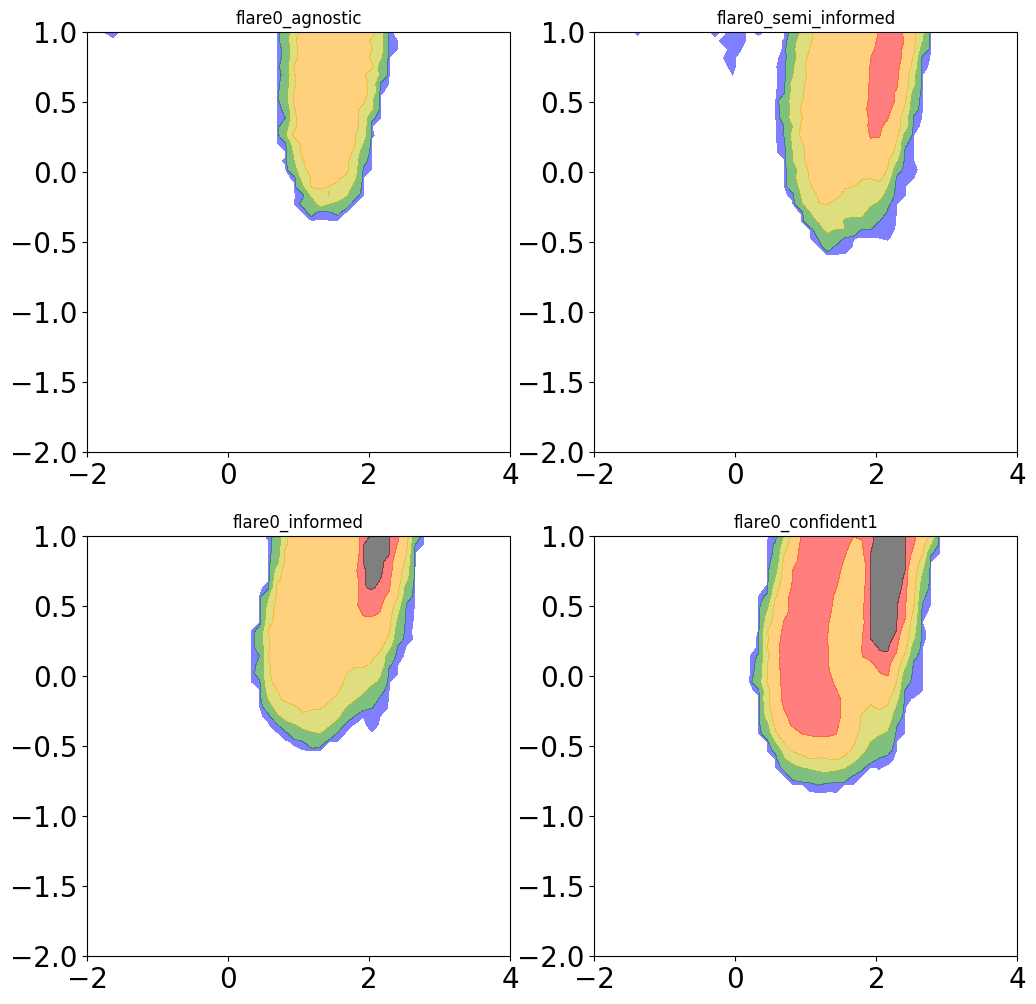

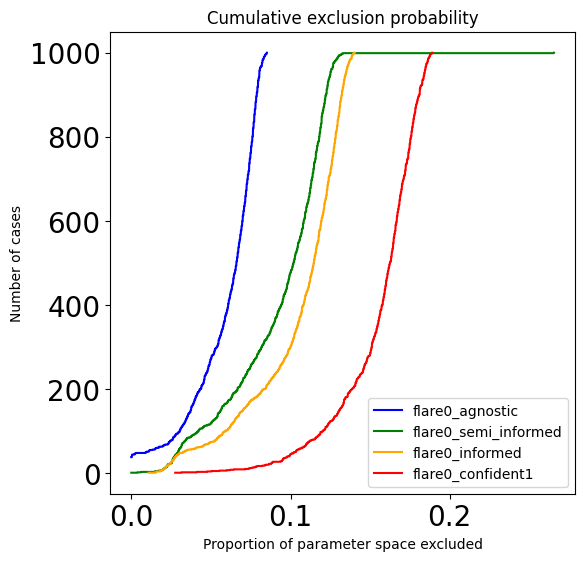

In [19]:
# contour_matrices['flare0_agnostic'] = None
# priors['flare0_agnostic']['predictions'] = None

# colors=['r','#FFA500','y','g','b','k']
colors=['b','g','y','#FFA500','r','k']
line_colors=['b','g','#FFA500','r']
if __name__ == "__main__":
    fig = plt.figure(figsize=(12,12))
    figh = plt.figure(figsize=(6,6))
    figh.add_subplot(1,1,1)
    for i in range(len(names)):
        
        name = names[i]
        
        try:
            contour_matrix = contour_matrices[name]
        except KeyError:
            try:
                with open(os.getcwd()+'/contour_matrix-'+name+'.pickle', 'rb') as file: contour_matrix = pickle.load(file)
            except FileNotFoundError:
                contour_matrix = None
        try:
            exclusion_area = exclusion_areas[name]
        except KeyError:
            try:
                with open(os.getcwd()+'/exclusion_areas-'+name+'.pickle', 'rb') as file: exclusion_area = pickle.load(file)
            except FileNotFoundError:
                exclusion_area = None
        
        fig.add_subplot(2,2,i+1)
        fig.axes[-1].set_title(name)
        contour_matrix,exclusion_area,_,_ = generate_expected_limits(
            priors[name]['samples_explim'],
            priors[name]['samples_prior'],
            bounds = [priors[name]['bounds'][0], priors[name]['bounds'][1]],
            predictions=priors[name]['predictions'],
            ax=fig.axes[-1],
            levels = [0.003,0.046,0.318,0.682,0.954,0.997,1],
            contour_matrix=contour_matrix,
            exclusion_areas=exclusion_area,
            colors=colors,
            alpha_variable=False,
            n_cores = 4,
            trainer=trainer,
            net=priors[name]['net']
        )

        figh.axes[-1].set_title('Cumulative exclusion probability')
        h,alpha = np.histogram(exclusion_area, bins=50*50+1)
        figh.axes[-1].plot(alpha[:-1],np.cumsum(h), color=line_colors[i],label=name)
        figh.axes[-1].legend()
        figh.axes[-1].set_xlabel('Proportion of parameter space excluded')
        figh.axes[-1].set_ylabel('Number of cases')

        contour_matrices[name] = contour_matrix
        exclusion_areas[name] = exclusion_area
        with open(os.getcwd()+'/contour_matrix-'+name+'.pickle','wb') as file: pickle.dump(contour_matrix, file)
        with open(os.getcwd()+'/exclusion_areas-'+name+'.pickle','wb') as file: pickle.dump(exclusion_area, file)